# Code to create a forcing file to use by Lagrangian LES
## By Ehsan Erfani   @UW on Feb. 2022    


In [36]:
import datetime as dt
import numpy as np
import os
import xarray as xr
import matplotlib.pyplot as plt
import glob
import pandas as pd
import time
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from pandas import Series, DataFrame
from netCDF4 import Dataset
from math import log10
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings("ignore")
import math

## Read input files and define parameters

In [37]:
##### read various files
forcing     = Dataset('Forcings_ShipTracks_01_01.nc', mode='r+')  # A default forcing file to start from
subdir      = '201904231900_37p671_-131p410'
#subdir      = '201904231900_33p33_-134p60'
#subdir      = '201904241700_31p609_-129p404'
new_forc_nm = './' + subdir + '/Forcings_ShipTracks_01_01.nc'

## These are trajectory files:
MERRA_data  = Dataset('../Lagrangian_project/trajectory_files/' + subdir + '/st01_72h_forward_1.0.nc')
MERRA_datab = Dataset('../Lagrangian_project/trajectory_files/' + subdir + '/st01_48h_backward_1.0.nc')


#### Parameters:

# start time:
yyyy     = int(subdir[0:4])
mm       = int(subdir[4:6])
dd       = int(subdir[6:8]) 
Obs_jump = int(subdir[8:10])  # time of the original point: hours since 00Z of the same day 

init_time= str(yyyy) + '-' + f"{mm:02n}" + '-' + f"{dd:02n}" + ' 00Z' 

bdate    = nbdate = int(str(yyyy)[2:] + f"{mm:02n}" + f"{dd:02n}")

# constants from SAM's SRC/params.f90
Rd    = 287
Cp    = 1004
L     = 2.5e6  # latent heat of vaporization: J/kg
g     = 9.81   # gravitation

## Reading various variables from forcing and ERA5 data

In [38]:
## Read variables in the CSET forcing file:
lat      = forcing.variables['lat'][:]             
lon      = forcing.variables['lon'][:] 
lev      = forcing.variables['lev'][:]             
tsec     = forcing.variables['tsec'][:]     # Time in seconds after 00Z on nbdate"             
calday   = forcing.variables['calday'][:]   # Time in days since Jan. 01, 2019
year     = forcing.variables['year'][:]             
month    = forcing.variables['month'][:]             
day      = forcing.variables['day'][:]             
hour     = forcing.variables['hour'][:]             
phis     = forcing.variables['phis'][:]     # Surface Geopotential: m2/s2        
Ps       = forcing.variables['Ps'][:]       # Surface Pressure, Pa         
Ptend    = forcing.variables['Ptend'][:]      # tendency_of_surface_air_pressure           
Tg       = forcing.variables['Tg'][:]       # Surface Temperature (SST if over water): K
shflx    = forcing.variables['shflx'][:]           # Surface Sensible Heat Flux:
lhflx    = forcing.variables['lhflx'][:]           # Surface Latent Heat Flux:
Tsair    = forcing.variables['Tsair'][:]
qsrf     = forcing.variables['qsrf'][:]     # Surface Water Vapor Mass Mixing ratio (extrapolated to z=0): kg/kg
u_traj   = forcing.variables['u_traj'][:]
v_traj   = forcing.variables['v_traj'][:]
CTH      = forcing.variables['CTH'][:]      # MODIS cloud top height: km
u        = forcing.variables['u'][:]
v        = forcing.variables['v'][:]
ug       = forcing.variables['ug'][:]
vg       = forcing.variables['vg'][:]
omega    = forcing.variables['omega'][:]    # Vertical Pressure Velocity: Pa/s
T        = forcing.variables['T'][:]        # Liquid Water Temperature From ERA-5 (converted from theta_l, for initialization): K
q        = forcing.variables['q'][:]        # Total Water Mass Mixing Ratio From ERA-5
divT     = forcing.variables['divT'][:]     # Large-scale Horizontal Temperature Advection: K/s
divq     = forcing.variables['divq'][:]     # Large-scale Horizontal Advection of Water Vapor Mass Mixing Ratio: kg/s
z        = forcing.variables['z'][:]        # Geopotential height from ERA-5:
Tref     = forcing.variables['Tref'][:]     # Reference Absolute Temperature if available. Otherwise, T: K
qref     = forcing.variables['qref'][:]     # Reference Water Vapor Mass Mixing Ratio if available. Otherwise, q: kg/kg
Tinit    = forcing.variables['Tinit'][:]    # Absolute Temperature from Idealized Aircraft Sounding if available. Otherwise, T K
qinit    = forcing.variables['qinit'][:]    # Water Vapor Mass Mixing Ratio from Idealized Aircraft Sounding if available. Otherwise, q: kg/kg
o3mmr    = forcing.variables['o3mmr'][:]
Na_accum = forcing.variables['Na_accum'][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
qa_accum = forcing.variables['qa_accum'][:] # Accumulation mode aerosol mass mixing ratio from MERRA2: kg/kg

#######
fo_test = Dataset(new_forc_nm)
Na_accum_test = fo_test.variables['Na_accum'][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
lev_test      = fo_test.variables['lev'][:]             
z_test        = fo_test.variables['z'][:]        # Geopotential height from ERA-5:

In [40]:
#diff_t = (T_time.shape[0] - calday.shape[0])
diff_t = 2
def read_var_1D(var_name):
    var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):], \
                              MERRA_data.variables[var_name][:-2]), axis=0)
    return var

def read_var_2D(var_name):
    var = np.concatenate( ( MERRA_datab.variables[var_name][(-Obs_jump+1):,:], \
                              MERRA_data.variables[var_name][:-2,:]), axis=0)
    return var

In [41]:
## Read variables in the trajectory file:
T_time = np.concatenate( ( (MERRA_datab.variables['time'][(-Obs_jump+1):] - MERRA_datab.variables['time'][-Obs_jump+1]) / 24, \
                                  (MERRA_data.variables['time'][:-2] + Obs_jump - 1) / 24), axis=0)


MERRA_RHO      = read_var_2D('MERRA_AIRDENS')    # air_density: kg/m3                     
MERRA_H        = read_var_2D('MERRA_H')          # mid_layer_heights
MERRA_Na_tot   = read_var_2D('MERRA_Na_tot') / MERRA_RHO      # total aerosol from MERRA: converted to 1/kg
MERRA_acc_mass = read_var_2D('MERRA_acc_mass')   # accumulation mode aerosol mass: kg/kg

T_level    = MERRA_data.variables['level'][:]  # pressure_level: mb         
T_lev      = MERRA_data.variables['lev'][:]    # model level pressure: mb   
T_lat      = read_var_1D('lat')                     
T_lon      = read_var_1D('lon')                     
T_height   = read_var_1D('height')                     
T_pres     = read_var_1D('pres')              # trajectory pressure: hPa                  
T_traj_u   = read_var_1D('traj_u')            # U component of trajectory velocity: m/s                
T_traj_v   = read_var_1D('traj_v')                     
T_traj_hdg = read_var_1D('traj_hdg')          # Trajectory heading: deg                   
T_traj_spd = read_var_1D('traj_spd')          # Trajectory speed: m/s                   
        
ERA_w    = read_var_2D('ERA_w')           # Vertical velocity: Pa/s
ERA_r    = read_var_2D('ERA_r')           # relative_humidity: %
ERA_t    = read_var_2D('ERA_t')           # air_temperature: K
ERA_o3   = read_var_2D('ERA_o3')  
ERA_u    = read_var_2D('ERA_u')  
ERA_v    = read_var_2D('ERA_v')  
ERA_q    = read_var_2D('ERA_q')          # specific_humidity: converted to kg/kg
ERA_z    = read_var_2D('ERA_z')          # geopotential: m**2 s**-2
ERA_clwc = read_var_2D('ERA_clwc')       # Specific cloud water content: kg kg**-1
ERA_dzdx = read_var_2D('ERA_dzdx')       # eastward_gradient_of_geopotential: m**2 s**-2 m**-1
ERA_dzdy = read_var_2D('ERA_dzdy')       # northward_gradient_of_geopotential
ERA_dtdx = read_var_2D('ERA_dtdx') 
ERA_dtdy = read_var_2D('ERA_dtdy') 
ERA_dqdx = read_var_2D('ERA_dqdx') 
ERA_dqdy = read_var_2D('ERA_dqdy') 
ERA_T_adv = read_var_2D('ERA_T_adv')    # trajectory_relative_advection_of_temperature: K s**-1
ERA_q_adv = read_var_2D('ERA_q_adv') 

ERA_sst  = read_var_1D('ERA_sst')        # Sea surface temperature: K
ERA_sp   = read_var_1D('ERA_sp')         # Surface pressure: Pa
ERA_sshf = - read_var_1D('ERA_sshf')      # Instantaneous surface sensible heat flux: W/m2
ERA_slhf = - read_var_1D('ERA_slhf')      # Instantaneous surface sensible heat flux: W/m2

## Necessary calculations, conversions, and interpolations

In [42]:
##### convert geopotential to geopotential height:
ERA_z = ERA_z / g 

##### Issue with water vapor variable at the top of model due to interpolation.
##### Extrapolate upwards from value at 70hPa (last 10th values)
i_lev = 10
for i in range(ERA_q.shape[0]):
    ERA_q[i,:i_lev] = ERA_q[i,i_lev]
    
##### Provide one ozone sounding by averaging over time
ERA_o3_m = np.nanmean(ERA_o3, 0)

##### change ERA specific humidity, cloud liquid specific humidity and  
# horizontal advection of specific humidity to mass mixing ratios.
ERA_clwc_mmr = ERA_clwc / (1 - ERA_q)
ERA_qv_mmr   = ERA_q / (1 - ERA_q)
ERA_q_adv    = ERA_q_adv / (1 - ERA_q)

###### Change ERA temperature to liquid-water temperature
###### and water vapor to total water by adding the effect of cloud liquid
ERA_qt_mmr = ERA_qv_mmr + ERA_clwc_mmr
ERA_tl     = ERA_t - (L / Cp) * ERA_clwc_mmr


####### coordinate variables. Assign as the initial location of the trajectory:
lat = T_lat[0]
lon = T_lon[0]

###### Time variables:
# calday (real): calendar day of forcings
calday  = T_time + dt.date(yyyy, mm, dd).timetuple().tm_yday

year     = calday.copy().astype(int)
month    = calday.copy().astype(int)
day      = calday.copy().astype(int)
for i in range(len(day)):
    res_date = dt.date(int(yyyy), 1, 1) + dt.timedelta(days = int(calday[i]) - 1)
    year[i]  = res_date.year
    month[i] = res_date.month
    day[i]   = res_date.day

hour  = ((calday - calday[0]) * 24) % 24
tsec = T_time * 24 * 3600

##### change pressure unit to Pa, if not already:
T_level_1 = T_level.copy()
if max(T_level_1) < 2e3:
    T_level_1 = T_level_1 * 100

T_lev_1 = T_lev.copy()
if max(T_lev_1) < 2e3:
    T_lev_1 = T_lev_1 * 100

###### Surface forcing variables from ERA5:
Ps[:,0,0]     = ERA_sp
Tg[:,0,0]     = ERA_sst
u_traj[:,0,0] = T_traj_u
v_traj[:,0,0] = T_traj_v
shflx[:]      = 0.
lhflx[:]      = 0.

try:
    CTH[:,0,0] = MODIS_CTH
except:
    CTH[:] = 0.      # In case, the MODIS CTH is not included in the trajectory package

CTH[:] = 0.      

# change SST unit to K, if not already:
if max(Tg) < 150:
    Tg = Tg + 273.15
    
Ptend[1:,0,0] = np.diff(ERA_sp) / np.diff(tsec)
Ptend[0,0,0]  = Ptend[1,0,0]


##### extrapolate ERA5 t and q to surface:
for k in range(len(tsec)):
    f = interpolate.interp1d(T_level_1, ERA_q[k,:], bounds_error=False, fill_value="extrapolate")
    qsrf[k,0,0] = f(Ps[k,0,0])
    f = interpolate.interp1d(T_level_1, ERA_t[k,:], bounds_error=False, fill_value="extrapolate")
    Tsair[k,0,0] = f(Ps[k,0,0])

In [43]:
##### interpolate the time-height variables to the forcing pressure grid
def interpolate_3D(inp, outp):
    for k in range(len(tsec)):
        f = interpolate.interp1d(T_level_1, inp[k,:])
        outp[k,:,0,0] = f(np.array(lev))
    return outp

def interpolate_MERRA(inp, outp):
    for k in range(len(tsec)):
        f = interpolate.interp1d(T_lev_1, inp[k,:], bounds_error=False, fill_value="extrapolate")
        outp[k,:,0,0] = f(np.array(lev))
    return outp


dzdx  = u.copy()
dzdy  = u.copy()
dzdx[:] = 0.
dzdy[:] = 0.

u     = interpolate_3D(ERA_u, u)
v     = interpolate_3D(ERA_v, v)
omega = interpolate_3D(ERA_w, omega)
T     = interpolate_3D(ERA_tl, T)
q     = interpolate_3D(ERA_qt_mmr, q)
z     = interpolate_3D(ERA_z, z)
o3mmr = interpolate_3D(ERA_o3, o3mmr)
divT  = interpolate_3D(ERA_T_adv, divT)
divq  = interpolate_3D(ERA_q_adv, divq)
dzdx  = interpolate_3D(ERA_dzdx, dzdx)
dzdy  = interpolate_3D(ERA_dzdy, dzdy)

Na_accum = interpolate_MERRA(MERRA_Na_tot, Na_accum)
qa_accum = interpolate_MERRA(MERRA_acc_mass, qa_accum)

##### Convert Na from #/mg to #/kg:
Na_accum = Na_accum * 1e6

##### soundings from ERA5 is used to compute Tl and qt reference profiles
Tref = T.copy()
qref = q.copy()

##### ditto for initial profiles 
Tinit = T.copy()
qinit = q.copy()

##### Calculate geostrophic winds:
f_cor = (4 * math.pi / 86400.) * math.sin( T_lat[0] * math.pi / 180. )   # coriolis parameter
ug = -(1. / f_cor) * dzdy
vg =  (1. / f_cor) * dzdx

##### forcings should be zero above the tropopause:
for k in range(len(tsec)):
    i_trop = np.nanmax( np.where(T[k,:,0,0] == np.nanmin(T[k,:,0,0]))[0] )
    omega[k,:i_trop,0,0] = 0.
    divT[ k,:i_trop,0,0] = 0.
    divq[ k,:i_trop,0,0] = 0.
    
##### Surface omega should be zero:
omega[:,-1,0,0] = 0.

##### Surface pressure tendency should be zero, because it is equivalent to surface omega, which was set to zero.
Ptend[:] = 0.

## Write variables to the forcing file

In [9]:
#### Creating attributes:
forcing.author      = 'Ehsan Erfani @UW'
forcing.institution = 'University of Washington, Seattle'
forcing.date        = str(dt.date.today())
forcing.comment     = 'Forcings for Ship Track 01 01 (April 2019). Generated\
 and converted to netcdf SCAM IOP format by Ehsan Erfani @UW'

In [10]:
#### Writing Data:
forcing.variables['lat']     [:]       = lat
forcing.variables['lon']     [:]       = lon
forcing.variables['lev']     [:]       = lev
forcing.variables['tsec']    [:]       = tsec
forcing.variables['calday']  [:]       = calday
forcing.variables['year']    [:]       = year
forcing.variables['month']   [:]       = month
forcing.variables['day']     [:]       = day
forcing.variables['hour']    [:]       = hour
forcing.variables['nbdate']  [:]       = nbdate 
forcing.variables['bdate']   [:]       = bdate 
forcing.variables['phis']    [:,:]     = phis
forcing.variables['Ps']      [:,:,:]   = Ps
forcing.variables['Ptend']   [:,:,:]   = Ptend
forcing.variables['Tg']      [:,:,:]   = Tg
forcing.variables['shflx']   [:,:,:]   = shflx
forcing.variables['lhflx']   [:,:,:]   = lhflx
forcing.variables['Tsair']   [:,:,:]   = Tsair
forcing.variables['qsrf']    [:,:,:]   = qsrf
forcing.variables['u_traj']  [:,:,:]   = u_traj
forcing.variables['v_traj']  [:,:,:]   = v_traj
forcing.variables['CTH']     [:,:,:]   = CTH
forcing.variables['u']       [:,:,:,:] = u
forcing.variables['v']       [:,:,:,:] = v
forcing.variables['ug']      [:,:,:,:] = ug
forcing.variables['vg']      [:,:,:,:] = vg
forcing.variables['omega']   [:,:,:,:] = omega
forcing.variables['T']       [:,:,:,:] = T
forcing.variables['q']       [:,:,:,:] = q
forcing.variables['divT']    [:,:,:,:] = divT
forcing.variables['divq']    [:,:,:,:] = divq
forcing.variables['z']       [:,:,:,:] = z
forcing.variables['Tref']    [:,:,:,:] = Tref
forcing.variables['qref']    [:,:,:,:] = qref
forcing.variables['Tinit']   [:,:,:,:] = Tinit
forcing.variables['qinit']   [:,:,:,:] = qinit
forcing.variables['o3mmr']   [:,:,:,:] = o3mmr
forcing.variables['Na_accum'][:,:,:,:] = Na_accum
forcing.variables['qa_accum'][:,:,:,:] = qa_accum

In [11]:
forcing.close()

## Verifying that the forcing file is created properly:

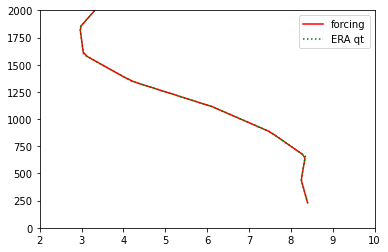

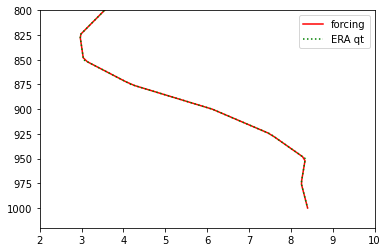

In [60]:
idx_t = 19

#####
plt.figure()
plt.plot(q[idx_t,:,0,0]*1000, z[idx_t,:,0,0], 'r', label='forcing')
plt.plot(ERA_qt_mmr[idx_t,:]*1000, ERA_z[idx_t,:], 'g:', label='ERA qt')
#plt.plot(forcing_q_org[idx_t,:,0,0]*1000, forcing_z_org[idx_t,:,0,0], 'b:', label='forcing original')
plt.xlim(2,10)
plt.ylim(0, 2000)
plt.legend()
plt.show()

plt.figure()
plt.plot(q[idx_t,:,0,0]*1000, lev/100, 'r', label='forcing')
plt.plot(ERA_qt_mmr[idx_t,:]*1000, T_level, 'g:', label='ERA qt')
#plt.plot(forcing_q_org[idx_t,:,0,0]*1000, forcing_z_org[idx_t,:,0,0], 'b:', label='forcing original')
plt.xlim(2,10)
plt.ylim([1020, 800])
#plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [12]:
forcing     = Dataset('Forcings_ShipTracks_01_01.nc')

var_others = ['lat','lon','lev','tsec','calday','year','month','day','hour','phis']

## Read variables in the CSET forcing file:
lat      = forcing.variables['lat'][:]             
lon      = forcing.variables['lon'][:] 
lev      = forcing.variables['lev'][:]             
tsec     = forcing.variables['tsec'][:]     # Time in seconds after 00Z on nbdate"             
calday   = forcing.variables['calday'][:]   # Time in days since Jan. 01, 2019
year     = forcing.variables['year'][:]             
month    = forcing.variables['month'][:]             
day      = forcing.variables['day'][:]             
hour     = forcing.variables['hour'][:]             
phis     = forcing.variables['phis'][:]     # Surface Geopotential: m2/s2        
Ps       = forcing.variables['Ps'][:]       # Surface Pressure, Pa         
Ptend    = forcing.variables['Ptend'][:]      # tendency_of_surface_air_pressure           
Tg       = forcing.variables['Tg'][:]       # Surface Temperature (SST if over water): K
shflx    = forcing.variables['shflx'][:]           # Surface Sensible Heat Flux:
lhflx    = forcing.variables['lhflx'][:]           # Surface Latent Heat Flux:
Tsair    = forcing.variables['Tsair'][:]
qsrf     = forcing.variables['qsrf'][:]     # Surface Water Vapor Mass Mixing ratio (extrapolated to z=0): kg/kg
u_traj   = forcing.variables['u_traj'][:]
v_traj   = forcing.variables['v_traj'][:]
CTH      = forcing.variables['CTH'][:]      # MODIS cloud top height: km
u        = forcing.variables['u'][:]
v        = forcing.variables['v'][:]
ug       = forcing.variables['ug'][:]
vg       = forcing.variables['vg'][:]
omega    = forcing.variables['omega'][:]    # Vertical Pressure Velocity: Pa/s
T        = forcing.variables['T'][:]        # Liquid Water Temperature From ERA-5 (converted from theta_l, for initialization): K
q        = forcing.variables['q'][:]        # Total Water Mass Mixing Ratio From ERA-5
divT     = forcing.variables['divT'][:]     # Large-scale Horizontal Temperature Advection: K/s
divq     = forcing.variables['divq'][:]     # Large-scale Horizontal Advection of Water Vapor Mass Mixing Ratio: kg/s
z        = forcing.variables['z'][:]        # Geopotential height from ERA-5:
Tref     = forcing.variables['Tref'][:]     # Ref. Temperature: K
qref     = forcing.variables['qref'][:]     # Ref. Mass Mixing Ratio: kg/kg
Tinit    = forcing.variables['Tinit'][:]    # Temperature from Idealized Aircraft Sounding: K
qinit    = forcing.variables['qinit'][:]    # Mass Mixing Ratio from Idealized Aircraft Sounding: kg/kg
o3mmr    = forcing.variables['o3mmr'][:]
Na_accum = forcing.variables['Na_accum'][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
qa_accum = forcing.variables['qa_accum'][:] # Accumulation mode aerosol mass mixing ratio from MERRA2: kg/kg

fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z[0,:,0,0], fday) # making meshgrid

## Calculate interpolated MERRA density:
MERRA_RHO_intrp    = Na_accum.copy()
MERRA_RHO_intrp[:] = np.nan
MERRA_RHO_intrp    = interpolate_MERRA(MERRA_RHO, MERRA_RHO_intrp)

## Calculate vertical velocity of forcing:
w_forc = omega / (g * MERRA_RHO_intrp)

##### Move forcing z from mid levels to pressure levels
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if j == z.shape[1] - 1:
            z[i,j,0,0] = (z[i,j,0,0] + 0) / 2
        else:
            z[i,j,0,0] = (z[i,j,0,0] + z[i,j+1,0,0]) / 2

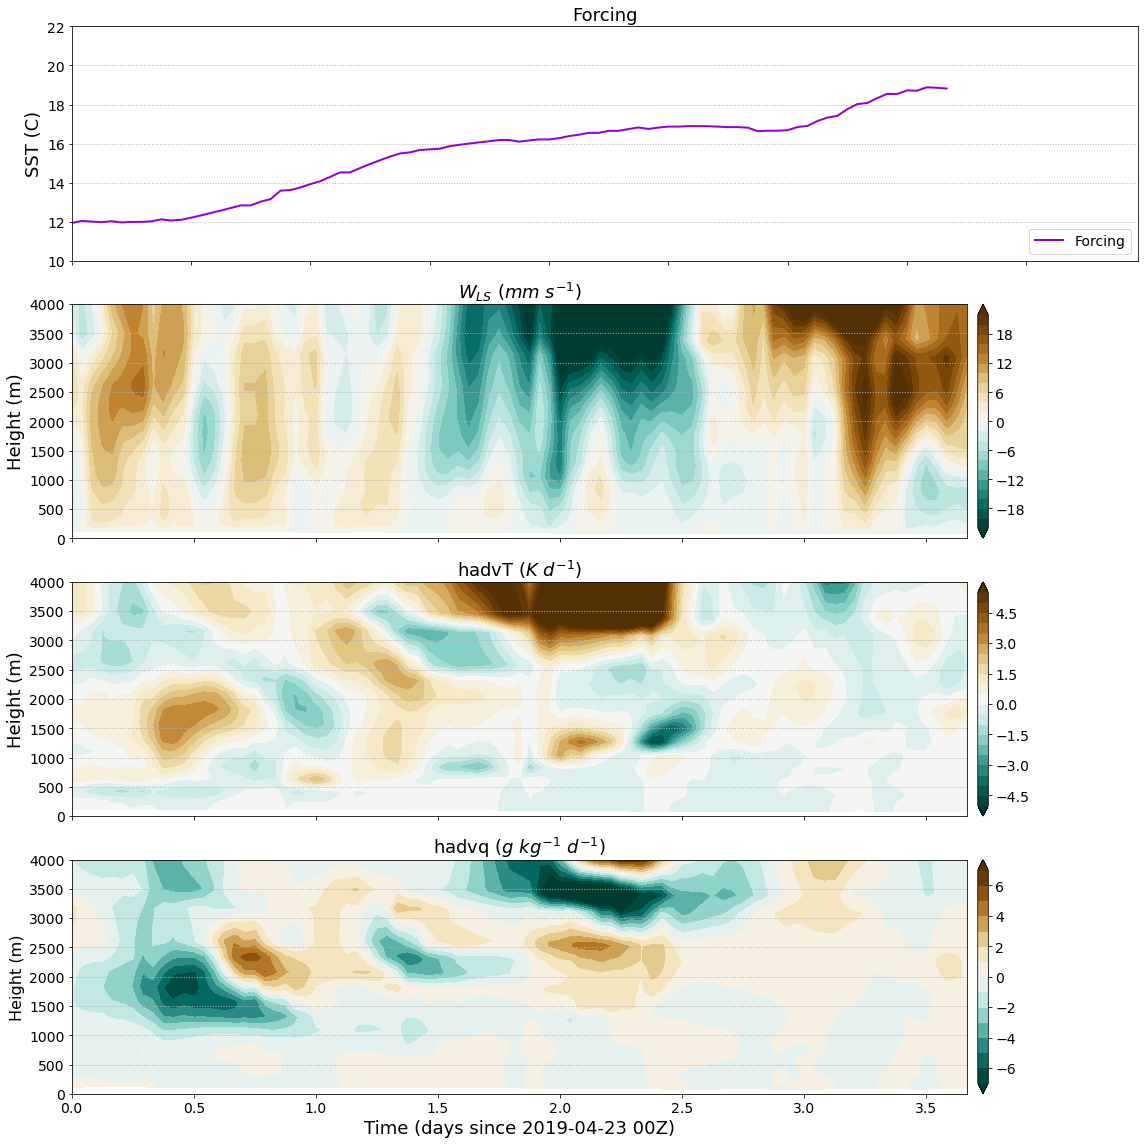

In [13]:
lngh = 15
box = 5
fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z[0,:,0,0], fday) # making meshgrid
start = 0
xlim = fday[-1]
ylim = 4000

#########
fig, axis = plt.subplots(4, 1,figsize=(16,16))

i = 0
axis[i].set_ylabel('SST (C)', fontsize = '18')
axis[i].set_title('Forcing', fontsize = '18')
axis[i].set_xlim([start, xlim + 0.8])
axis[i].set_ylim([10, 22])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


i = 1
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$W_{LS}$ ($mm$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 2
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('hadvT ($K$ $d^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

i = 3
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('hadvq ($g$ $kg^{-1}$ $d^{-1}$)', fontsize = '18')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
cc1 = axis[i].plot(fday, Tg[:,0,0] - 273.15, '-', color='darkviolet', linewidth= '2', label='Forcing')
leg1 = axis[i].legend(fontsize = '14', loc='lower right')

i = 1
clevs = np.arange(-22, 24, 2)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], w_forc[:,:,0,0] * 1000, clevs, extend='both', cmap = 'BrBG_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 2
clevs = np.arange(-5, 6, .5)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], divT[:,:,0,0] * 24 * 3600, clevs, extend='both', cmap = 'BrBG_r')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 3
clevs = np.arange(-7, 8, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], divq[:,:,0,0] * 24 * 3600 * 1000, clevs, extend='both', cmap = 'BrBG_r')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

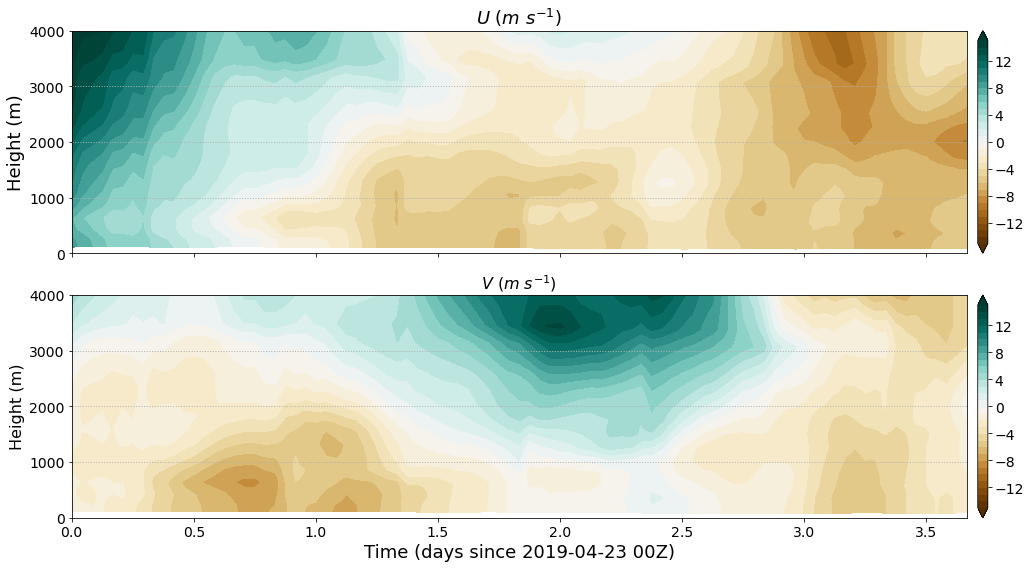

In [14]:
lngh = 15
box = 5
fday = calday - int(calday[0])
dummy, fday_mg = np.meshgrid(z[0,:,0,0], fday) # making meshgrid
start = 0
xlim = fday[-1]
ylim = 4000
init_time = '2019-04-23 00Z' 

#########
fig, axis = plt.subplots(2, 1,figsize=(16,8))

i = 0
axis[i].set_ylabel('Height (m)', fontsize = '18')
axis[i].set_title('$U$ ($m$ $s^{-1}$)', fontsize = '18')
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].axes.get_xaxis().set_ticklabels([])
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)


i = 1
axis[i].set_ylabel('Height (m)', fontsize = '16')
axis[i].set_title('$V$ ($m$ $s^{-1}$)', fontsize = '16')# , (MBL: MERRA2-UHSAS log-log fit; FT: MERRA2 corrected)
axis[i].set_xlim([start, xlim])
axis[i].set_ylim([0, ylim])
axis[i].set_xlabel('Time (days since '+init_time+')', fontsize = '18')
axis[i].tick_params(axis='both', which='major', labelsize=14)
axis[i].grid(linestyle=':', axis='y', linewidth=1)

#######
i = 0
clevs = np.arange(-15, 16, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], u[:,:,0,0], clevs, extend='both', cmap = 'BrBG')
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)
cb.ax.tick_params(labelsize=14)

i = 1
clevs = np.arange(-15, 16, 1)
cc1 = axis[i].contourf(fday_mg, z[:,:,0,0], v[:,:,0,0], clevs, extend='both', cmap = 'BrBG')#, norm=matplotlib.colors.LogNorm())
cb = plt.colorbar(cc1, ax = axis[i], pad = 0.01)#, ticks=ticks)
cb.ax.tick_params(labelsize=14)


plt.tight_layout(w_pad=1)
plt.show()

## A test to make sure the variables and their units are correct

In [15]:
forcing_cset = Dataset('/home/disk/eos1/erfani/CSET/SAMUWgh-CSET-3D3D3D-ProgAer-FTMERRA/CSET_RF06_Tr2p3/Forcings_CSET_rf06_traj2p3_v1p2_BL40_FT40_150.nc')
vars_2d      = ['Ps','Ptend','Tg','shflx','lhflx','Tsair','qsrf','u_traj','v_traj','CTH']
vars_3d      = ['u','v','ug','vg','omega','T','q','divT','divq','Tref','qref','Tinit','qinit','o3mmr','Na_accum','qa_accum']

In [16]:
#### Make sure there is no NaN:
for i in range(len(vars_2d)):
    var_test = forcing.variables[vars_2d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test[:,0,0]) == 1))
print('\n\n')
for i in range(len(vars_2d)):
    var_test = forcing_cset.variables[vars_2d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test[:,0,0]) == 1))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)



(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73,
       74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88]),)


In [17]:
for i in range(len(vars_3d)):
    var_test = forcing.variables[vars_3d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test[:,:,0,0]) == 1))
print('\n\n')
for i in range(len(vars_3d)):
    var_test = forcing_cset.variables[vars_3d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test[:,:,0,0]) == 1))


(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))



(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=

In [18]:
var_others = ['lat','lon','lev','tsec','calday','year','month','day','hour','phis']

for i in range(len(var_others)):
    var_test = forcing.variables[var_others[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test) == 1))
print('\n\n')
for i in range(len(var_others)):
    var_test = forcing_cset.variables[var_others[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    print(np.where(np.isnan(var_test) == 1))


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64))



(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64), array([], dtype=int64))


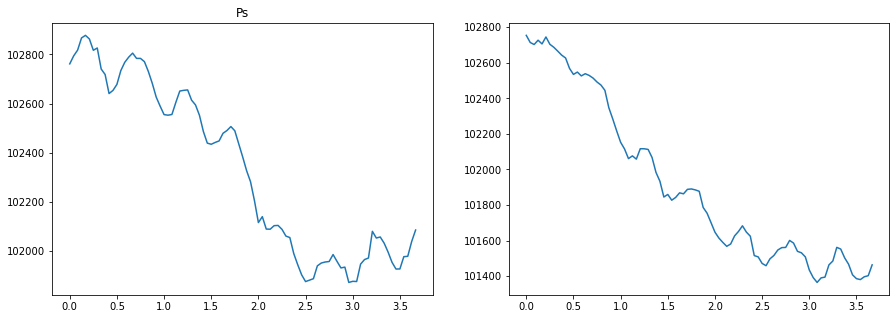

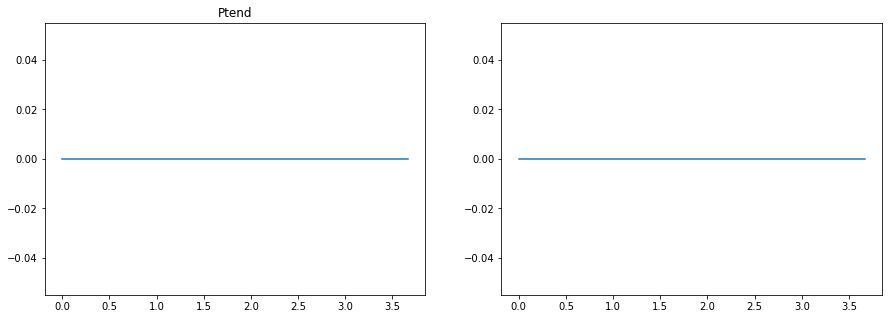

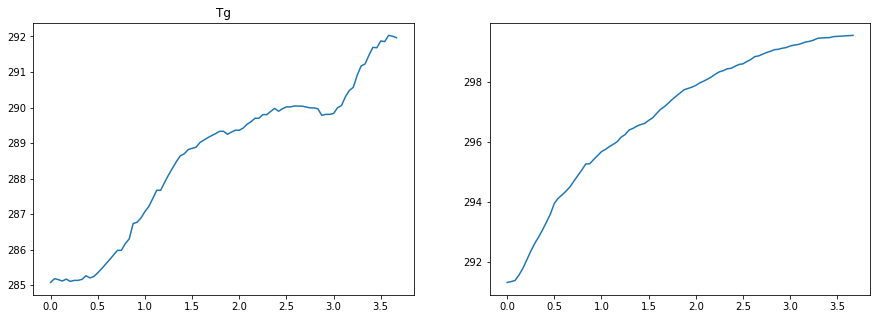

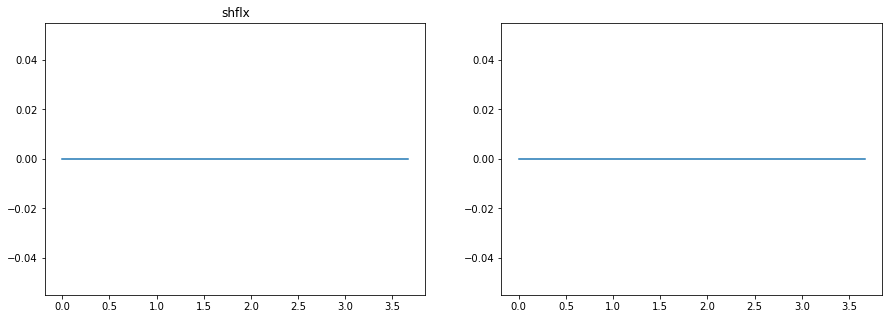

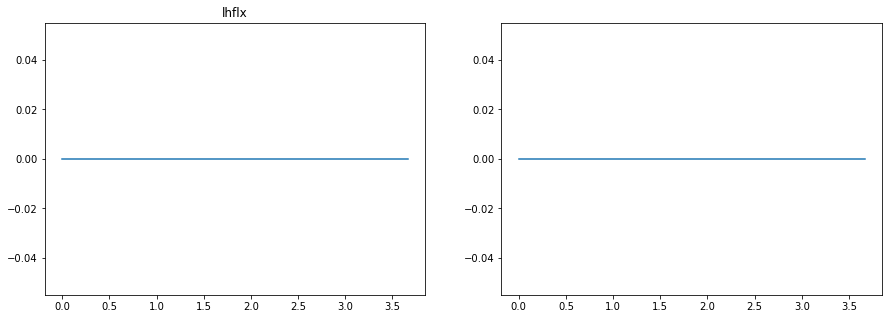

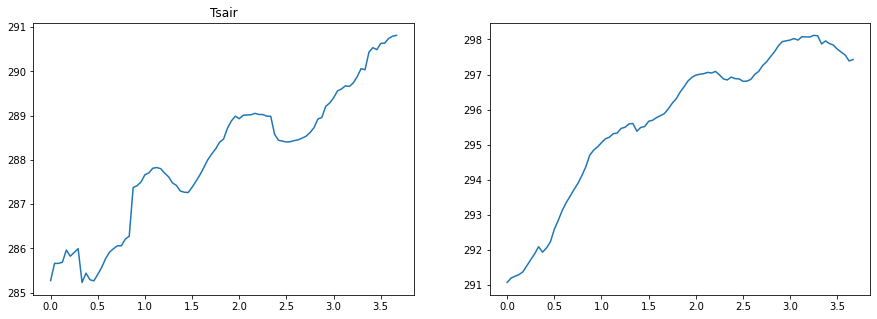

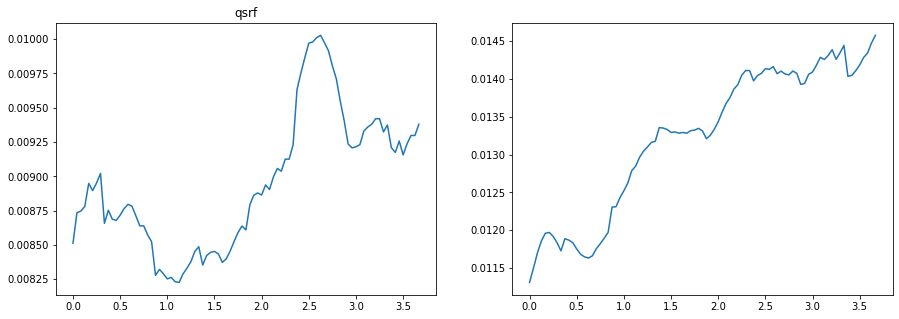

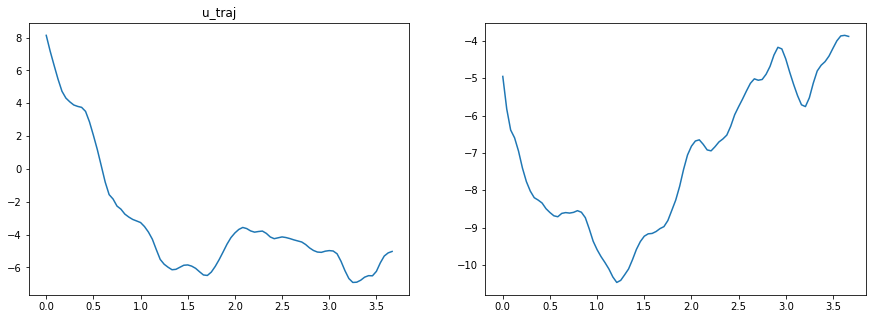

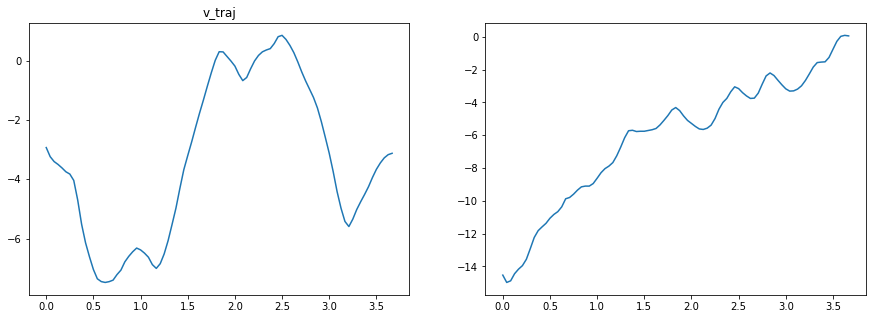

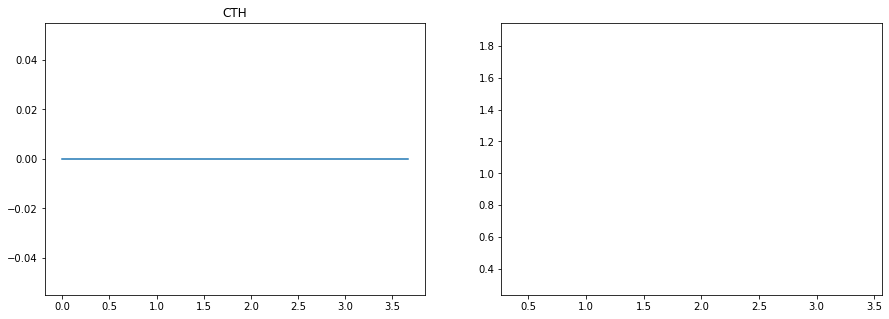

In [19]:
### This is a comparison between two different dates and times (obviously, they should not be the same).

for i in range(len(vars_2d)):
    jj = 0
    fig, axis = plt.subplots(1, 2,figsize=(15,5))
    var_test = forcing.variables[vars_2d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    cc1 = axis[jj].plot(fday, var_test[:,0,0])
    axis[jj].set_title(vars_2d[i])
    
    jj = 1
    var_test = forcing_cset.variables[vars_2d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    cc1 = axis[jj].plot(fday, var_test[:,0,0])


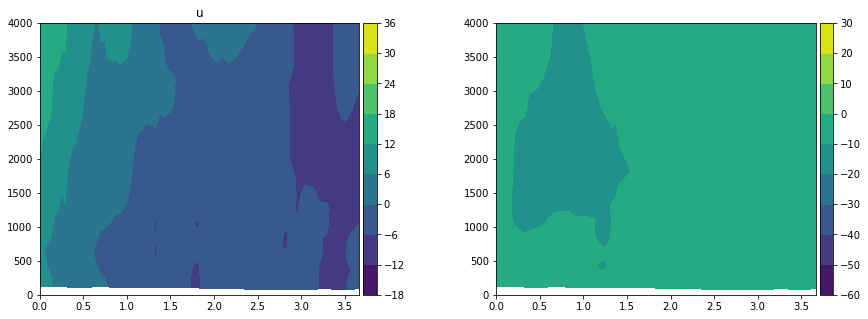

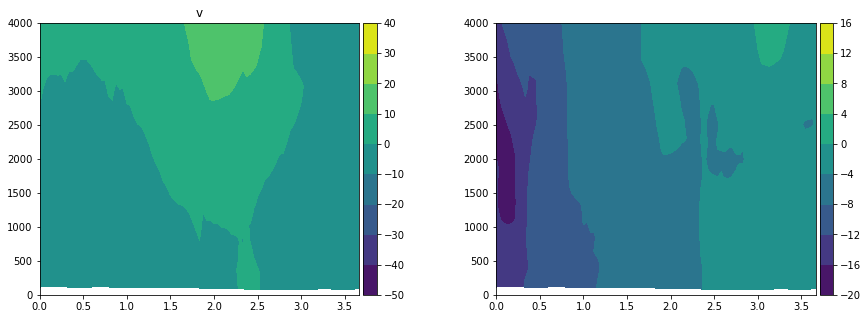

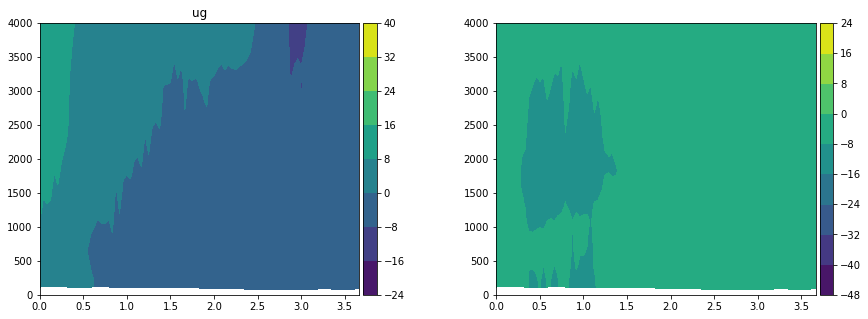

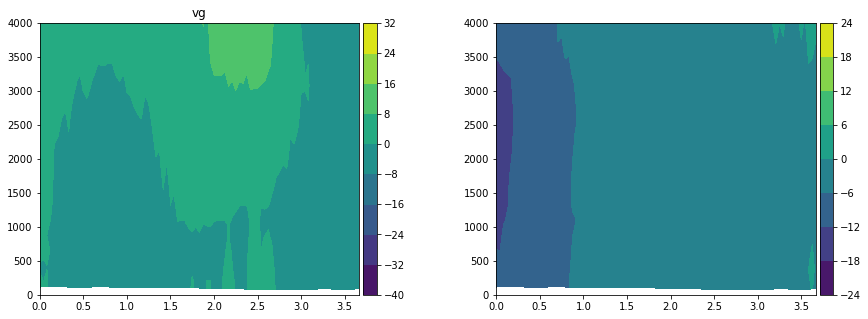

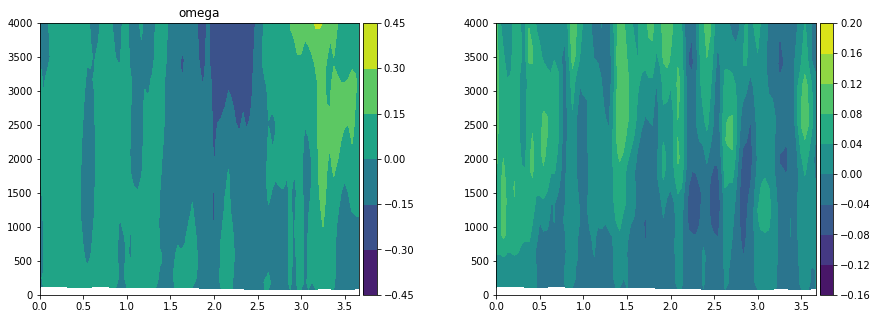

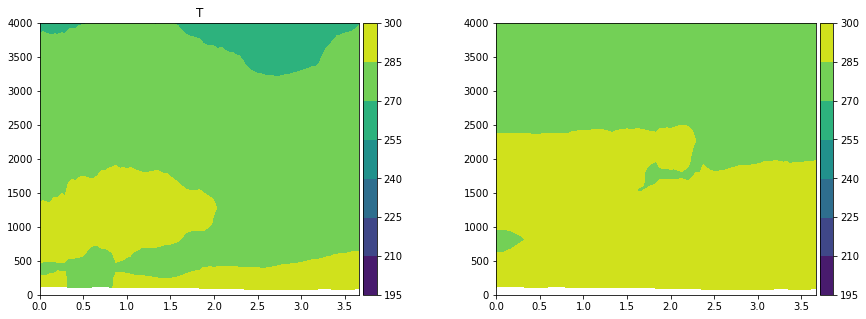

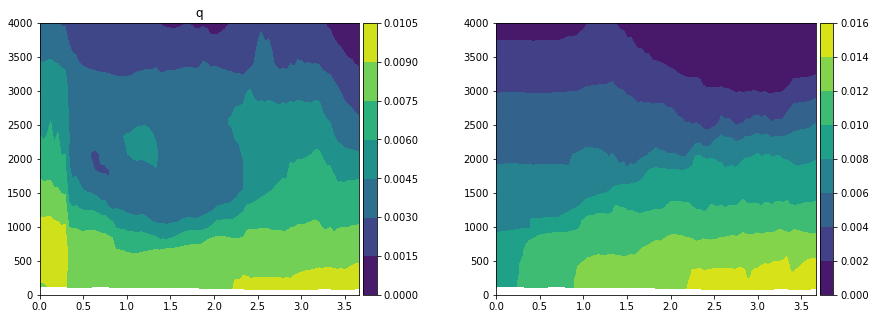

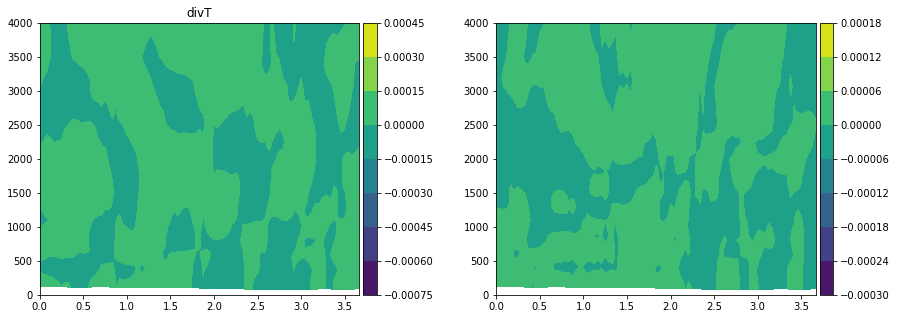

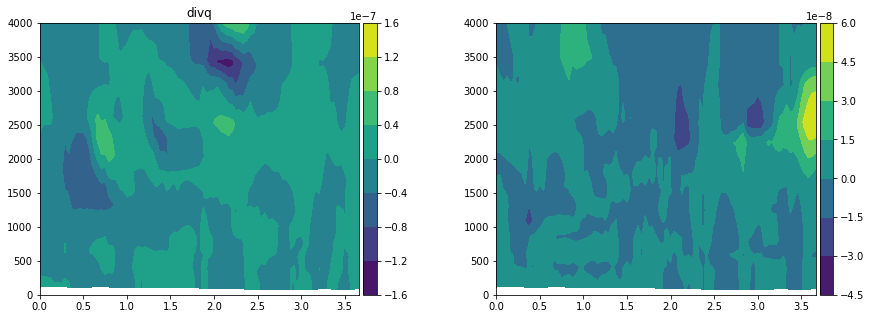

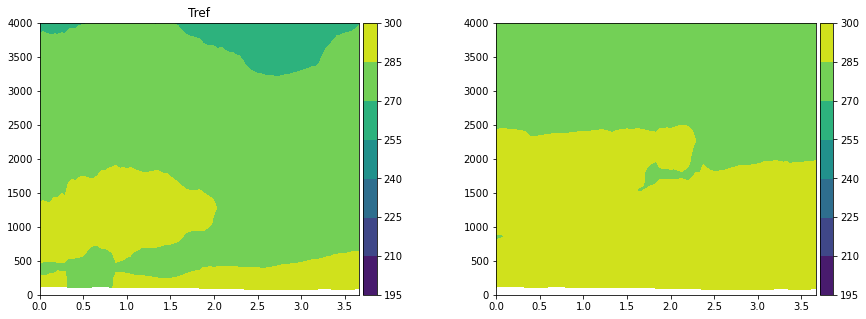

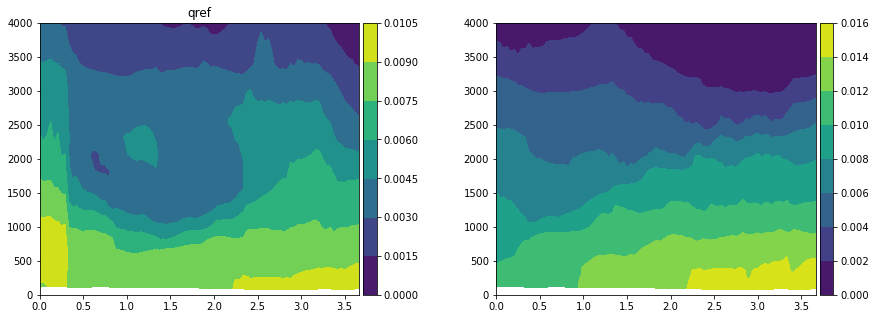

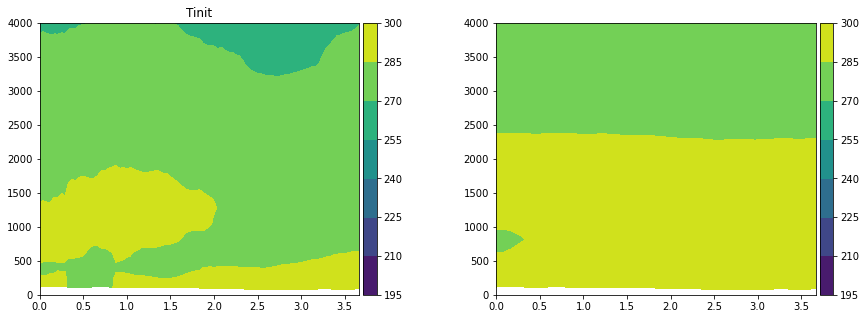

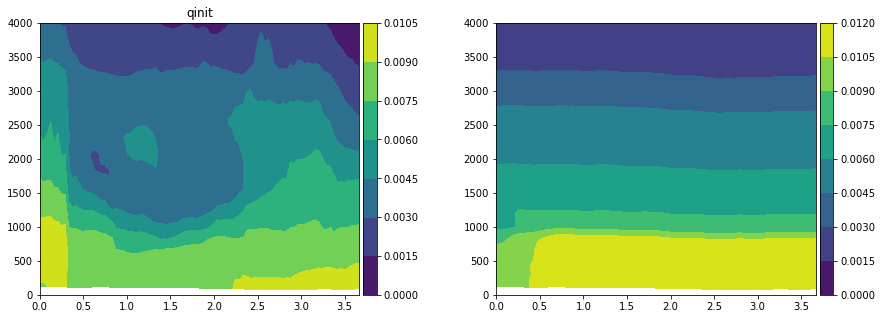

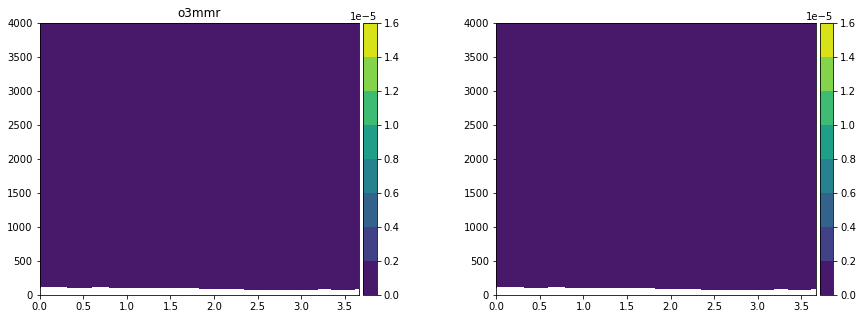

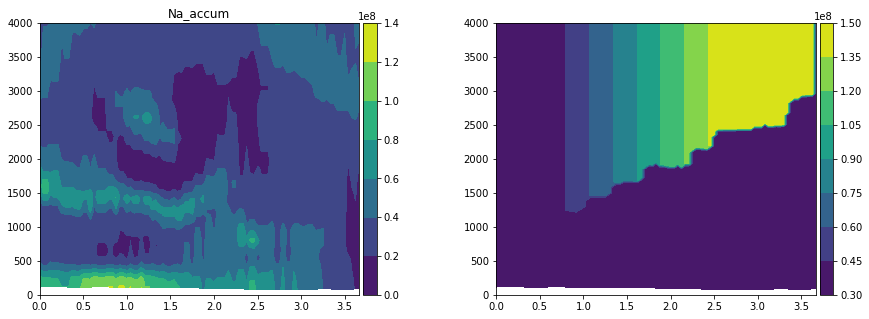

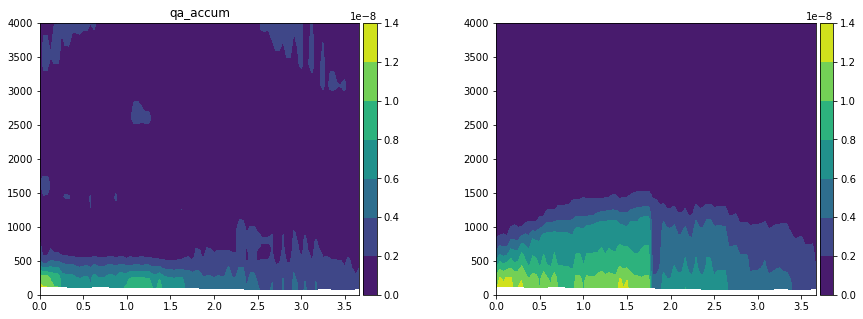

In [20]:
for i in range(len(vars_3d)):
    jj = 0
    fig, axis = plt.subplots(1, 2,figsize=(15,5))
    var_test = forcing.variables[vars_3d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    cc1 = axis[jj].contourf(fday_mg, z[:,:,0,0], var_test[:,:,0,0])
    cb = plt.colorbar(cc1, ax = axis[jj], pad = 0.01)#, ticks=ticks)
    axis[jj].set_ylim([0, 4000])
    axis[jj].set_title(vars_3d[i])
    
    jj = 1
    var_test = forcing_cset.variables[vars_3d[i]][:] # Accumulation mode aerosol number mixing ratio from MERRA2: 1/kg
    cc1 = axis[jj].contourf(fday_mg, z[:,:,0,0], var_test[:,:,0,0])
    cb = plt.colorbar(cc1, ax = axis[jj], pad = 0.01)#, ticks=ticks)
    axis[jj].set_ylim([0, 4000])

In [26]:
## Printing the content of the forcing file:
print(forcing)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    author: Ehsan Erfani @UW
    institution: University of Washington, Seattle
    Conventions: CF-1.3
    date: 2022-03-22
    comment: Forcings for Ship Track 01 01 (April 2019). Generated and converted to netcdf SCAM IOP format by Ehsan Erfani @UW
    dimensions(sizes): lat(1), lon(1), lev(101), time(89)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float32 lev(lev), int32 tsec(time), float32 calday(time), int32 year(time), int32 month(time), int32 day(time), float32 hour(time), int32 nbdate(), int32 bdate(), float32 phis(lon,lat), float32 Ps(time,lat,lon), float32 Ptend(time,lat,lon), float32 Tg(time,lat,lon), float32 shflx(time,lat,lon), float32 lhflx(time,lat,lon), float32 Tsair(time,lat,lon), float32 qsrf(time,lat,lon), float32 u_traj(time,lat,lon), float32 v_traj(time,lat,lon), float32 CTH(time,lat,lon), float32 u(time,lev,lat,lon), float32 v(time,lev,lat,lon), flo